In [2]:
######################################################
#
# ReaSCAN: on the mission for AGI with language.
#
# Author: Zhengxuan Wu (wuzhengx@stanford.edu)
#
# Descriptions:
# This script is used as initial plannings for the 
# ReaSCAN engine. It illustrate how to integrate different
# parts together, such as Mini-Grid gym etc..
#
# Notes:
# 1. We will leverage gSCAN core engines but with extensive 
# modifications for ReaSCAN. This ensures fairness of 
# comparisions.
######################################################

In [253]:
from collections import namedtuple, OrderedDict
import itertools
import os
import numpy as np
from typing import Tuple
from typing import List
from typing import Dict
import random
from itertools import product
import copy
import re
import random

from utils import one_hot
from utils import generate_possible_object_names
from utils import numpy_array_to_image

from vocabulary import *
from object_vocabulary import *
from world import *
from grammer import *
from simulator import *

### Vocabulary Module

In [254]:
# test out the vocabulary
intransitive_verbs = ["walk"]
transitive_verbs = ["push", "pull"]
adverbs = ["quickly", "slowly", "while zigzagging", "while spinning", "cautiously", "hesitantly"]
nouns = ["circle", "cylinder", "square", "box"]
color_adjectives = ["red", "blue", "green", "yellow"]
size_adjectives = ["big", "small"]
relative_pronouns = ["that is"]
relation_clauses = ["in the same row as", 
                    "in the same column as", 
                    "in the same color as", 
                    "in the same shape as", 
                    "in the same size as",
                    "inside of"]
vocabulary = Vocabulary.initialize(intransitive_verbs=intransitive_verbs,
                                   transitive_verbs=transitive_verbs, adverbs=adverbs, nouns=nouns,
                                   color_adjectives=color_adjectives,
                                   size_adjectives=size_adjectives, 
                                   relative_pronouns=relative_pronouns, 
                                   relation_clauses=relation_clauses)

In [255]:
# test out the object vocab
min_object_size = 1
max_object_size = 4
object_vocabulary = ObjectVocabulary(shapes=vocabulary.get_semantic_shapes(),
                                     colors=vocabulary.get_semantic_colors(),
                                     min_size=min_object_size, max_size=max_object_size)
# object_vocabulary.generate_objects()

### Situtation Module

In [256]:
# test out situation repr
TEST_SITUATION_1 = Situation(grid_size=15, agent_position=Position(row=7, column=2), agent_direction=INT_TO_DIR[0],
                             target_object=PositionedObject(object=Object(size=2, color='red', shape='circle'),
                                                            position=Position(row=10, column=4),
                                                            vector=np.array([1, 0, 1])),
                             placed_objects=[PositionedObject(object=Object(size=2, color='red', shape='circle'),
                                                              position=Position(row=10, column=4),
                                                              vector=np.array([1, 0, 1])),
                                             PositionedObject(object=Object(size=4, color='green', shape='circle'),
                                                              position=Position(row=3, column=12),
                                                              vector=np.array([0, 1, 0]))], carrying=None)
# TEST_SITUATION_1.to_representation()

In [257]:
# test out our new object definition
PositionedObject(object=Object(size=4, color='green', shape='box'),
                 position=Position(row=3, column=12),
                 vector=np.array([0, 1, 0]), overflow=True, overlap=True)

PositionedObject(object=Object(size=4, color='green', shape='box'), position=Position(column=12, row=3), vector=array([0, 1, 0]), overflow=True, overlap=True)

### World Module with Mini-Gym

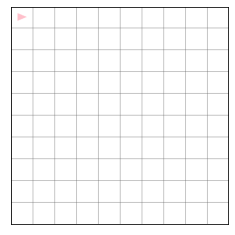

In [258]:
# test out the world
import matplotlib as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
os.environ['QT_QPA_PLATFORM']='offscreen'
world = World(grid_size=10, colors=vocabulary.get_semantic_colors(),
              object_vocabulary=object_vocabulary,
              shapes=vocabulary.get_semantic_shapes(),
              save_directory="./tmp/")
world_rgb = world.render_simple()

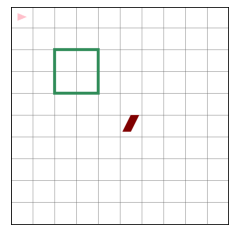

In [259]:
# try to place an object on to the map
world.clear_situation()
# world.place_object(Object(size=4, color="green", shape="box"), position=Position(row=3, column=3))
world.place_object(Object(size=2, color="green", shape="box"), position=Position(row=2, column=2))
world.place_object(Object(size=3, color="red", shape="cylinder"), position=Position(row=5, column=5))
_ = world.render_simple()

### ReaSCAN Grammer Module

In [260]:
grammer = Grammer(vocabulary)

In [261]:
grammer._sample_grammer_pattern_reascan_train()

['$OBJ_0 ^ $OBJ_1', '$OBJ_0 ^ $OBJ_1 & $OBJ_2', '$OBJ_0 ^ $OBJ_1 ^ $OBJ_2']

In [16]:
grammer.build_dependency_graph('$OBJ_0 ^ $OBJ_1 & $OBJ_2 ^ $OBJ_3 & $OBJ_4')

OrderedDict([('$OBJ_0', ['$OBJ_1', '$OBJ_2']),
             ('$OBJ_2', ['$OBJ_3', '$OBJ_4'])])

In [17]:
grammer.sample_object_relation_grammer(
    '$OBJ_0', 
    grammer.build_dependency_graph('$OBJ_0 ^ $OBJ_1 & $OBJ_2'))[:5]

[({'$OBJ_0': '$SHAPE', '$OBJ_1': '$SHAPE', '$OBJ_2': '$SHAPE'},
  OrderedDict([(('$OBJ_0', '$OBJ_1'), '$SAME_ROW'),
               (('$OBJ_0', '$OBJ_2'), '$SAME_COLUMN')])),
 ({'$OBJ_0': '$SHAPE', '$OBJ_1': '$SHAPE', '$OBJ_2': '$SHAPE'},
  OrderedDict([(('$OBJ_0', '$OBJ_1'), '$SAME_ROW'),
               (('$OBJ_0', '$OBJ_2'), '$IS_INSIDE')])),
 ({'$OBJ_0': '$SHAPE', '$OBJ_1': '$SHAPE', '$OBJ_2': '$SHAPE'},
  OrderedDict([(('$OBJ_0', '$OBJ_1'), '$SAME_ROW'),
               (('$OBJ_0', '$OBJ_2'), '$SAME_SIZE')])),
 ({'$OBJ_0': '$SHAPE', '$OBJ_1': '$SHAPE', '$OBJ_2': '$SHAPE'},
  OrderedDict([(('$OBJ_0', '$OBJ_1'), '$SAME_ROW'),
               (('$OBJ_0', '$OBJ_2'), '$SAME_COLOR')])),
 ({'$OBJ_0': '$SHAPE', '$OBJ_1': '$SHAPE', '$OBJ_2': '$SHAPE'},
  OrderedDict([(('$OBJ_0', '$OBJ_1'), '$SAME_COLUMN'),
               (('$OBJ_0', '$OBJ_2'), '$SAME_ROW')]))]

In [19]:
obj_pattern_map = {'$OBJ_0': '$ABS_SHAPE', '$OBJ_1': '$SIZE $SHAPE', '$OBJ_2': '$SHAPE'}
rel_map = {('$OBJ_0', '$OBJ_1'): '$SAME_ROW', ('$OBJ_0', '$OBJ_2'): '$SAME_COLUMN'}
grammer_pattern = '$OBJ_0 ^ $OBJ_1 & $OBJ_2'
grammer.grounding_grammer_with_vocabulary(grammer_pattern, obj_pattern_map, rel_map)

[{'$OBJ_0': 'object', '$OBJ_1': 'big circle', '$OBJ_2': 'circle'},
 {'$OBJ_0': 'object', '$OBJ_1': 'big circle', '$OBJ_2': 'cylinder'},
 {'$OBJ_0': 'object', '$OBJ_1': 'big circle', '$OBJ_2': 'square'},
 {'$OBJ_0': 'object', '$OBJ_1': 'big cylinder', '$OBJ_2': 'circle'},
 {'$OBJ_0': 'object', '$OBJ_1': 'big cylinder', '$OBJ_2': 'cylinder'},
 {'$OBJ_0': 'object', '$OBJ_1': 'big cylinder', '$OBJ_2': 'square'},
 {'$OBJ_0': 'object', '$OBJ_1': 'big square', '$OBJ_2': 'circle'},
 {'$OBJ_0': 'object', '$OBJ_1': 'big square', '$OBJ_2': 'cylinder'},
 {'$OBJ_0': 'object', '$OBJ_1': 'big square', '$OBJ_2': 'square'},
 {'$OBJ_0': 'object', '$OBJ_1': 'small circle', '$OBJ_2': 'circle'},
 {'$OBJ_0': 'object', '$OBJ_1': 'small circle', '$OBJ_2': 'cylinder'},
 {'$OBJ_0': 'object', '$OBJ_1': 'small circle', '$OBJ_2': 'square'},
 {'$OBJ_0': 'object', '$OBJ_1': 'small cylinder', '$OBJ_2': 'circle'},
 {'$OBJ_0': 'object', '$OBJ_1': 'small cylinder', '$OBJ_2': 'cylinder'},
 {'$OBJ_0': 'object', '$OBJ_1': 

### ReaSCAN Simulator

In [ ]:
# Valid (covers uniqueness as well)
# Necessary (all relations in the command are needed)
# Distracting

In [459]:
from collections import namedtuple, OrderedDict
import itertools
import os
import numpy as np
from typing import Tuple
from typing import List
from typing import Dict
import random
from itertools import product
import copy
import re
import random

from utils import one_hot
from utils import generate_possible_object_names
from utils import numpy_array_to_image

from vocabulary import *
from object_vocabulary import *
from world import *
from grammer import *

class Simulator(object):
    """
    This convert generated grammers into a world/situation.
    
    Sample Situation:
    Situation(grid_size=15, agent_position=Position(row=7, column=2), agent_direction=INT_TO_DIR[0],
              target_object=PositionedObject(object=Object(size=2, color='red', shape='circle'),
                                             position=Position(row=10, column=4),
                                             vector=np.array([1, 0, 1])),
              placed_objects=[PositionedObject(object=Object(size=2, color='red', shape='circle'),
                                               position=Position(row=10, column=4),
                                               vector=np.array([1, 0, 1])),
                              PositionedObject(object=Object(size=4, color='green', shape='circle'),
                                               position=Position(row=3, column=12),
                                               vector=np.array([0, 1, 0]))], carrying=None)
                                               
    Sample Placement in the World:
    world.place_object(Object(size=2, color="green", shape="box"), position=Position(row=2, column=2))
    
    """
    def __init__(self, object_vocabulary, vocabulary, grid_size=15, 
                 n_distractor_min=3,
                 n_distractor_max=5,
                 save_directory="./tmp/"):
        self.object_vocabulary = object_vocabulary
        self.vocabulary = vocabulary
        self.grid_size = grid_size
        self.n_distractor_min = n_distractor_min
        self.n_distractor_max = n_distractor_max

        self._world = World(grid_size=grid_size, colors=vocabulary.get_semantic_colors(),
                            object_vocabulary=object_vocabulary,
                            shapes=vocabulary.get_semantic_shapes(),
                            save_directory=save_directory)
        self._world.clear_situation()
    
    def sample_object_spec(self, obj_grammer, obj_pattern, obj_str, rel_map, 
                           is_root, obj_placed_map):
        obj_pattern = obj_pattern.split(" ")
        obj_str = obj_str.split(" ")
        color = None
        size = None
        shape = None
        if len(obj_str) == 3:
            size = self.object_vocabulary.sample_size_with_prior(prior=obj_str[0])
            color = obj_str[1]
            shape = obj_str[2]
        elif len(obj_str) == 2:
            if "$COLOR" in obj_pattern: # color + shape.
                size = self.object_vocabulary.sample_size()
                color = obj_str[0]
                shape = obj_str[1]
            elif "$SIZE" in obj_pattern: # size + shape.
                size = self.object_vocabulary.sample_size_with_prior(prior=obj_str[0])
                color = self.object_vocabulary.sample_color()
                shape = obj_str[1]
        elif len(obj_str) == 1:
            # it must be the object
            size = self.object_vocabulary.sample_size()
            color = self.object_vocabulary.sample_color()
            shape = obj_str[0]
        # Final handling for the shape.
        if shape == "object":
            shape = self.object_vocabulary.sample_shape()
            
        # Override size, color and shape based on relations.
        if not is_root:
            # Go through the rel.
            for pair, rel in rel_map.items():
                if obj_grammer == pair[-1]:
                    if pair[0] in obj_placed_map.keys():
                        # if this obj is acting as a child node
                        # then have to complain with parent node
                        if rel == "$SAME_SHAPE":
                            shape = obj_shape_map[pair[0]]
                        elif rel == "$SAME_COLOR":
                            color = obj_color_map[pair[0]]
                        elif rel == "$SAME_SIZE":
                            size = obj_size_map[pair[0]]
                        elif rel == "$IS_INSIDE":
                            # I think isinside is ok
                            # we can just play around with
                            # positions.
                            pass
        return Object(color=color,size=size,shape=shape)
                    
    def sample_object_position(self, sampled_obj, root, obj_grammer, rel_map, obj_placed_map, 
                               obj_position_map, retry_max=10):
        # If it is the first node, we directly return.
        if obj_grammer == root:
            sampled_pos = self._world.sample_position()
            return sampled_pos
                
        for _ in range(retry_max):
            obj_random_pos = self._world.sample_position()
            row = obj_random_pos.row
            col = obj_random_pos.column
            for pair, rel in rel_map.items():
                if obj_grammer == pair[-1]:
                    if pair[0] in obj_placed_map.keys():
                        # if this obj is acting as a child node
                        # then have to complain with parent node
                        if rel == "$SAME_ROW":
                            row = obj_position_map[pair[0]].row
                        elif rel == "$SAME_COLUMN":
                            col = obj_position_map[pair[0]].column
                        elif rel == "$IS_INSIDE":
                            # we need to make sure enclosure
                            size = sampled_obj.size
                            row_higher = min(obj_position_map[pair[0]].row, self.grid_size-size)
                            col_higher = min(obj_position_map[pair[0]].column, self.grid_size-size)
                            row_lower = max(obj_position_map[pair[0]].row-(size-1), 0)
                            col_lower = max(obj_position_map[pair[0]].column-(size-1), 0)
                            # consider the size and boundary as well
                            row = random.randint(row_lower, row_higher)
                            col = random.randint(col_lower, col_higher)
            proposed_position=Position(row=row, column=col)
            if sampled_obj.shape != "box":
                if not self._world.position_taken(proposed_position):
                    return proposed_position
            else:
                overlap_box = False
                for obj_str, obj in obj_placed_map.items():
                    if obj.shape == "box":
                        if obj_position_map[obj_str].row == row or \
                            obj_position_map[obj_str].column == col:
                            overlap_box = True
                            break
                if not overlap_box:
                    return proposed_position
        return -1 # Fail to propose a valid position.
    
    def sample_random_object_spec(self, size_exclude=None, 
                                  color_exclude=None, shape_exclude=None):
        d_size = self.object_vocabulary.sample_size(_exclude=size_exclude)
        d_color = self.object_vocabulary.sample_color(_exclude=color_exclude)
        d_shape = self.object_vocabulary.sample_shape(_exclude=shape_exclude)
        return Object(color=d_color,size=d_size,shape=d_shape)
    
    def sample_situations_from_grounded_grammer(self, grammer_pattern, 
                                                obj_pattern_map, rel_map, obj_map, root="$OBJ_0", 
                                                is_plot=False):
        # Clear current world.
        self._world.clear_situation()
        
        # Start placing objects with specs.
        obj_placed_map = {}
        obj_position_map = {}
        referred_obj = root
        for obj_grammer, obj_str in obj_map.items():
            # 1. Sample object.
            sampled_obj = self.sample_object_spec(
                obj_grammer,
                obj_pattern_map[obj_grammer], obj_str, rel_map, 
                is_root=obj_grammer==root, 
                obj_placed_map=obj_placed_map
            )
            
            # 2. Place on the world map.
            sampled_pos = self.sample_object_position(
                sampled_obj, root, obj_grammer, rel_map, 
                obj_placed_map, obj_position_map
            )
            
            if sampled_obj == -1 or sampled_pos == -1:
                return -1 # Fail to sample.

            self._world.place_object(
                sampled_obj, 
                position=sampled_pos, target=obj_grammer==root
            )
            obj_placed_map[obj_grammer] = sampled_obj
            obj_position_map[obj_grammer] = sampled_pos
        
        # ONGOING: We need to place distractors at each step.
        
        
        
        # 3. Place distractors.
        n_distractor = random.randint(self.n_distractor_min, self.n_distractor_max)
        core_obj_count = len(obj_placed_map)
        for i in range(0, n_distractor):
            distractor_idx = core_obj_count+i
            distractor_name = f"$OBJ_{distractor_idx}"
            sampled_distractor = self.sample_random_object_spec()
            sampled_dis_pos = self._world.sample_position()
            self._world.place_object(
                sampled_distractor, 
                position=sampled_dis_pos, target=False
            )
            obj_placed_map[distractor_name] = sampled_distractor
            obj_position_map[distractor_name] = sampled_dis_pos
        
        agent_position = self._world.sample_position()
        self._world.place_agent_at(agent_position)
        if is_plot:
            _ = self._world.render_simple()
        
        return {
            "obj_map" : obj_placed_map,
            "pos_map" : obj_position_map,
            "referred_obj" : referred_obj,
            "situation" : copy.deepcopy(self._world.get_current_situation())
        }
    
    # Deprecated
    def place_relational_distractors(self, current_plain_situation, original_grammer_pattern, 
                                     original_obj_pattern_map, original_rel_map, original_obj_map, 
                                     root="$OBJ_0"):
        """
        This function brings reasonings into the next level of play!
        AI can solve this? :)
        
        TODO: destruct the obj map!
        """
        distractors_placed = 0 
        tries = 10
        dis_size_map = {}
        dis_color_map = {}
        dis_shape_map = {}
        dis_placed_map = {}
        dis_row_map = {}
        dis_col_map = {}
        dis_pos_map = {}
        total_distractor_count = 0
        for i in range(0, tries):
            if distractors_placed >= self.relational_distractor_placement_max:
                break
            # soft_sample_situations_from_grounded_grammer
            rel_map = copy.deepcopy(original_rel_map)
            obj_map = copy.deepcopy(original_obj_map)
            # must remove one of the main relation
            rand_idx = []
            rand_i = 0
            for pair, rel in rel_map.items():
                if pair[0] == root:
                    rand_idx.append(rand_i)
                rand_i += 1
            rel_idx = random.sample(rand_idx, 1).pop()
            old_rel = rel_map[list(rel_map.keys())[rel_idx]]
            new_rel = set(["$SAME_ROW", "$SAME_COLUMN", "$SAME_SHAPE", "$SAME_COLOR", "$SAME_SIZE"]) - set([old_rel])
            new_rel = list(new_rel)
            new_rel = random.sample(new_rel, 1).pop()
            rel_map[list(rel_map.keys())[rel_idx]] = new_rel

            if old_rel == "$IS_INSIDE":
                # we also need to remove box
                new_obj = random.sample(["circle", "square", "cylinder"], 1).pop()
                obj_map[list(rel_map.keys())[rel_idx][-1]] = new_obj
            

            distractor_plain_situation = self.soft_sample_situations_from_grounded_grammer(
                original_grammer_pattern, 
                original_obj_pattern_map, rel_map, obj_map, 
                root="$OBJ_0")

            if distractor_plain_situation != -1:
                valid_distractor = True
                for pair, rel in rel_map.items():
                    if distractor_plain_situation["obj_row_map"][pair[0]] \
                        == distractor_plain_situation["obj_row_map"][pair[1]] and "$SAME_ROW" == old_rel:
                        valid_distractor = False
                        break
                    if distractor_plain_situation["obj_col_map"][pair[0]] \
                        == distractor_plain_situation["obj_col_map"][pair[1]] and "$SAME_COLUMN" == old_rel:
                        valid_distractor = False
                        break
                    if distractor_plain_situation["obj_shape_map"][pair[0]] \
                        == distractor_plain_situation["obj_shape_map"][pair[1]] and "$SAME_SHAPE" == old_rel:
                        valid_distractor = False
                        break
                    if distractor_plain_situation["obj_size_map"][pair[0]] \
                        == distractor_plain_situation["obj_size_map"][pair[1]] and "$SAME_SIZE" == old_rel:
                        valid_distractor = False
                        break
                    if distractor_plain_situation["obj_color_map"][pair[0]] \
                        == distractor_plain_situation["obj_color_map"][pair[1]] and "$SAME_COLOR" == old_rel:
                        valid_distractor = False
                        break
                    if old_rel == "$IS_INSIDE":
                        box_row = distractor_plain_situation["obj_row_map"][pair[1]]
                        box_col = distractor_plain_situation["obj_col_map"][pair[1]]
                        box_size = distractor_plain_situation["obj_size_map"][pair[1]]
                        d_row = distractor_plain_situation["obj_row_map"][pair[0]]
                        d_col = distractor_plain_situation["obj_col_map"][pair[0]]
                        if d_row >= box_row and d_row < box_row + box_size and \
                            d_col >= box_col and d_col < box_col + box_size:
                            valid_distractor = False
                            break
                
                for k, v in distractor_plain_situation["obj_size_map"].items():
                    d_size = distractor_plain_situation["obj_size_map"][k]
                    d_color = distractor_plain_situation["obj_color_map"][k]
                    d_shape = distractor_plain_situation["obj_shape_map"][k]
                    d_row = distractor_plain_situation["obj_row_map"][k]
                    d_col = distractor_plain_situation["obj_col_map"][k]                    
                    
                    if not self.valid_distractor(d_size, d_color, d_shape, d_row, d_col, current_plain_situation,
                                                 original_grammer_pattern, original_obj_pattern_map, 
                                                 rel_map, obj_map, [old_rel]):
                        valid_distractor = False
                        break
                if valid_distractor:
                    distractors_placed += 1
                    for k, v in distractor_plain_situation["obj_size_map"].items():
                        dis_name = f"DIS_{total_distractor_count}"
                        d_size = distractor_plain_situation["obj_size_map"][k]
                        d_color = distractor_plain_situation["obj_color_map"][k]
                        d_shape = distractor_plain_situation["obj_shape_map"][k]
                        d_row = distractor_plain_situation["obj_row_map"][k]
                        d_col = distractor_plain_situation["obj_col_map"][k]
                        d_random_pos = Position(row=d_row, column=d_col)
                        dis_size_map[dis_name] = {d_size}
                        dis_color_map[dis_name] = {d_color}
                        dis_shape_map[dis_name] = {d_shape}
                        dis_row_map[dis_name] = {d_row}
                        dis_col_map[dis_name] = {d_col}
                        dis_pos_map[dis_name] = {d_random_pos}
                        self._world.place_object(Object(size=d_size, color=d_color, shape=d_shape), 
                                             position=d_random_pos, target=False)
        return {
            "dis_size_map" : dis_size_map,
            "dis_color_map" : dis_color_map,
            "dis_shape_map" : dis_shape_map,
            "dis_row_map" : dis_row_map,
            "dis_col_map" : dis_col_map
        }
    
    # Deprecated
    def valid_distractor(self, d_size, d_color, d_shape, d_row, d_col, current_plain_situation,
                         grammer_pattern, obj_pattern_map, rel_map, obj_map, old_rel=None, root="$OBJ_0"):
        if old_rel is not None:
            # if one, fail!
            for pair, rel in rel_map.items():
                if pair[0] == root:
                    if d_row == current_plain_situation["obj_row_map"][pair[1]] and "$SAME_ROW" in old_rel:
                        return False
                    if d_col == current_plain_situation["obj_col_map"][pair[1]] and "$SAME_COLUMN" in old_rel:
                        return False
                    if d_shape == current_plain_situation["obj_shape_map"][pair[1]] and "$SAME_SHAPE" in old_rel:
                        return False
                    if d_size == current_plain_situation["obj_size_map"][pair[1]] and "$SAME_SIZE" in old_rel:
                        return False
                    if d_color == current_plain_situation["obj_color_map"][pair[1]] and "$SAME_COLOR" in old_rel:
                        return False
                    if old_rel == "$IS_INSIDE":
                        box_row = current_plain_situation["obj_row_map"][pair[1]]
                        box_col = current_plain_situation["obj_col_map"][pair[1]]
                        box_size = current_plain_situation["obj_size_map"][pair[1]]
                        if d_row >= box_row and d_row < box_row + box_size and \
                            d_col >= box_col and d_col < box_col + box_size:
                            return False

        valid_distractor = False
        for pair, rel in rel_map.items():
            if pair[0] == root:
                # the distractor cannot pertain the relation with the child node
                if rel == "$SAME_ROW":
                    if d_row != current_plain_situation["obj_row_map"][pair[1]]:
                        # find a relation break! good!
                        valid_distractor = True
                        break
                elif rel == "$SAME_COLUMN":
                    if d_col != current_plain_situation["obj_col_map"][pair[1]]:
                        # find a relation break! good!
                        valid_distractor = True
                        break
                elif rel == "$SAME_SHAPE":
                    if d_shape != current_plain_situation["obj_shape_map"][pair[1]]:
                        # find a relation break! good!
                        valid_distractor = True
                        break
                elif rel == "$SAME_COLOR":
                    if d_color != current_plain_situation["obj_color_map"][pair[1]]:
                        # find a relation break! good!
                        valid_distractor = True
                        break
                elif rel == "$SAME_SIZE":
                    if d_size != current_plain_situation["obj_size_map"][pair[1]]:
                        # find a relation break! good!
                        valid_distractor = True
                        break
                elif rel == "$IS_INSIDE":
                    box_row = current_plain_situation["obj_row_map"][pair[1]]
                    box_col = current_plain_situation["obj_col_map"][pair[1]]
                    box_size = current_plain_situation["obj_size_map"][pair[1]]
                    if d_row < box_row or d_row >= box_row + box_size:
                        # find a relation break! good!
                        valid_distractor = True
                        break
                    if d_col < box_col or d_col >= box_col + box_size:
                        # find a relation break! good!
                        valid_distractor = True
                        break
        return valid_distractor
    
    # Deprecated
    def place_random_distractors(self, current_plain_situation, grammer_pattern, 
                                 obj_pattern_map, rel_map, obj_map, root="$OBJ_0"):
        distractors_placed = 0 
        tries = 10
        dis_size_map = {}
        dis_color_map = {}
        dis_shape_map = {}
        dis_placed_map = {}
        dis_row_map = {}
        dis_col_map = {}
        dis_pos_map = {}
        for i in range(0, tries):
            if distractors_placed >= self.random_distractor_placement_max:
                break
            # we will try max time, but if fail, will just pass through.
            
            # the idea is to propose distractor at random
            # and the requirement is distractor cannot be the referred node
            
            d_size = self.object_vocabulary.sample_size()
            d_color = self.object_vocabulary.sample_color()
            d_shape = self.object_vocabulary.sample_shape()
            d_random_pos = self._world.sample_position()
            d_row = d_random_pos.row
            d_col = d_random_pos.column
            
            valid_distractor = False
            for pair, rel in rel_map.items():
                if pair[0] == root:
                    # the distractor cannot pertain the relation with the child node
                    if rel == "$SAME_ROW":
                        if d_row != current_plain_situation["obj_row_map"][pair[1]]:
                            # find a relation break! good!
                            valid_distractor = True
                            break
                    elif rel == "$SAME_COLUMN":
                        if d_col != current_plain_situation["obj_col_map"][pair[1]]:
                            # find a relation break! good!
                            valid_distractor = True
                            break
                    elif rel == "$SAME_SHAPE":
                        if d_shape != current_plain_situation["obj_shape_map"][pair[1]]:
                            # find a relation break! good!
                            valid_distractor = True
                            break
                    elif rel == "$SAME_COLOR":
                        if d_color != current_plain_situation["obj_color_map"][pair[1]]:
                            # find a relation break! good!
                            valid_distractor = True
                            break
                    elif rel == "$SAME_SIZE":
                        if d_size != current_plain_situation["obj_size_map"][pair[1]]:
                            # find a relation break! good!
                            valid_distractor = True
                            break
                    elif rel == "$IS_INSIDE":
                        box_row = current_plain_situation["obj_row_map"][pair[1]]
                        box_col = current_plain_situation["obj_col_map"][pair[1]]
                        box_size = current_plain_situation["obj_size_map"][pair[1]]
                        if d_row < box_row or d_row >= box_row + box_size:
                            # find a relation break! good!
                            valid_distractor = True
                            break
                        if d_col < box_col or d_col >= box_col + box_size:
                            # find a relation break! good!
                            valid_distractor = True
                            break
            if valid_distractor:
                dis_name = f"DIS_{distractors_placed}"
                dis_size_map[dis_name] = {d_size}
                dis_color_map[dis_name] = {d_color}
                dis_shape_map[dis_name] = {d_shape}
                dis_row_map[dis_name] = {d_row}
                dis_col_map[dis_name] = {d_col}
                dis_pos_map[dis_name] = {d_random_pos}
                distractors_placed += 1
                self._world.place_object(Object(size=d_size, color=d_color, shape=d_shape), 
                                         position=d_random_pos, target=False)
        return {
            "dis_size_map" : dis_size_map,
            "dis_color_map" : dis_color_map,
            "dis_shape_map" : dis_shape_map,
            "dis_row_map" : dis_row_map,
            "dis_col_map" : dis_col_map
        }

In [683]:
simulator = Simulator(
    object_vocabulary, vocabulary, 
    grid_size=6, 
    n_distractor_min=0,
    n_distractor_max=0
)

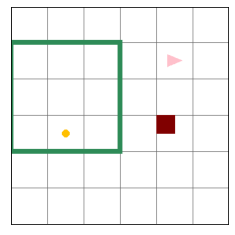

In [772]:
obj_pattern_map = {'$OBJ_0': '$ABS_SHAPE', '$OBJ_1': '$COLOR $SHAPE', '$OBJ_2': '$SHAPE'}
rel_map = {('$OBJ_0', '$OBJ_1'): '$SAME_ROW', ('$OBJ_0', '$OBJ_2'): '$IS_INSIDE'}
obj_map = {'$OBJ_0': 'object', '$OBJ_1': 'red square', '$OBJ_2': 'box'}
grammer_pattern = '$OBJ_0 ^ $OBJ_1 & $OBJ_2'

sampled_world = simulator.sample_situations_from_grounded_grammer(
    grammer_pattern, 
    obj_pattern_map, 
    rel_map, 
    obj_map,
    is_plot=True
)

In [774]:
sampled_world

{'obj_map': {'$OBJ_0': Object(size=1, color='yellow', shape='circle'),
  '$OBJ_1': Object(size=2, color='red', shape='square'),
  '$OBJ_2': Object(size=3, color='green', shape='box')},
 'pos_map': {'$OBJ_0': Position(column=1, row=3),
  '$OBJ_1': Position(column=4, row=3),
  '$OBJ_2': Position(column=0, row=1)},
 'referred_obj': '$OBJ_0',
 'situation': <world.Situation at 0x7f9a267d05c0>}

In [892]:
def sample_distractor_grammer(
    referent_grammer_pattern, 
    referent_obj_pattern_map,
    referent_rel_map,
    referent_obj_map, 
    sampled_world,
    surgery_operations=["REL_ADJUST", "OBJ_ADJUST"],
    object_vocabulary=None
):
    
    # First, let us make copies.
    distractor_grammer_pattern = copy.deepcopy(referent_grammer_pattern)
    distractor_obj_pattern_map = copy.deepcopy(referent_obj_pattern_map)
    distractor_rel_map = copy.deepcopy(referent_rel_map)
    distractor_obj_map = copy.deepcopy(referent_obj_map)
    
    # We may need to enforce the size of the distractor due to size descriptors!
    distractor_size_map = {}
    
    # To have valid distractor, the original relational map must
    # be missing some leaf edges.
    # e.g., A->B->C becomes A'->B (or object with same descriptor as B) 
    # assums arrow represents the same relational type. A' will be 
    # different than A since C is missing.
    
    leaf_edges = []
    for edge, relation in distractor_rel_map.items():
        is_leaf = True
        for _edge, _relation in distractor_rel_map.items():
            if edge[1] == _edge[0]:
                is_leaf = False
                break
        if is_leaf:
            leaf_edges.append(edge)

    # leaf_edges only contains a single pair, we continue to remove it.
    if len(leaf_edges) == 1:
        pass
    
    # To remove it, we can take the following actions:
    # 1. Change the relation type.
    # 2. Change the leaf node attributes.
    selected_leaf_edge = random.choice(leaf_edges)
    selected_surgery = random.choice(surgery_operations)
    if "box" in distractor_obj_map[selected_leaf_edge[1]] and \
        "$COLOR" not in distractor_obj_pattern_map[selected_leaf_edge[1]]:
        selected_surgery = "REL_ADJUST"
    
    if selected_surgery == "REL_ADJUST":
        if distractor_rel_map[selected_leaf_edge] == "$IS_INSIDE":
            # We also need to change the leaf object anyway.
            new_rels = ["$SAME_ROW", "$SAME_COLUMN", "$SAME_SHAPE", "$SAME_COLOR", "$SAME_SIZE"]
            new_rel = random.choice(new_rels)
            # Update fields.
            shape = object_vocabulary.sample_shape()
            distractor_rel_map[selected_leaf_edge] = new_rel
            distractor_obj_map[selected_leaf_edge[1]] = shape
            distractor_obj_pattern_map[selected_leaf_edge[1]] = '$SHAPE'
        else:
            new_rels = ["$SAME_ROW", "$SAME_COLUMN", "$SAME_SHAPE", "$SAME_COLOR", "$SAME_SIZE", "$IS_INSIDE"]
            new_rels = set(new_rels) - set([distractor_rel_map[selected_leaf_edge]])
            new_rel = random.choice(list(new_rels))
            if new_rel == "$IS_INSIDE":
                shape = "box"
                distractor_obj_map[selected_leaf_edge[1]] = shape
                distractor_obj_pattern_map[selected_leaf_edge[1]] = '$SHAPE'
            else:
                pass # What about we just don't update the shape?
            # Update fields.
            distractor_rel_map[selected_leaf_edge] = new_rel
    elif selected_surgery == "OBJ_ADJUST":
        original_object_name = selected_leaf_edge[1]
        original_object_str = distractor_obj_map[original_object_name]
        original_object = sampled_world['obj_map'][original_object_name]
        # Shape color, we can change, I think.
        adjustable_attributes = ["color", "shape"]
        adjust_attribute = random.choice(adjustable_attributes)
        # If the original object does not have color as attribute, sampling on color
        # is highly likely leading to non-unique referent targets.
        if "$COLOR" not in distractor_obj_pattern_map[original_object_name]:
            adjust_attribute = "shape"
        if "box" in original_object_str:
            adjust_attribute = "color"
        if adjust_attribute == "color":
            new_color = object_vocabulary.sample_color(_exclude=[original_object.color])
            new_object_str = new_color + " " + original_object.shape
        elif adjust_attribute == "shape":
            new_shape = object_vocabulary.sample_shape(_exclude=[original_object.shape])
            new_object_str = original_object.color + " " + new_shape
        new_object_grammer = "$COLOR $SHAPE"
        distractor_obj_map[original_object_name] = new_object_str
        distractor_obj_pattern_map[original_object_name] = new_object_grammer
    else:
        pass # Not implemented
    
    return [{
        "distractor_grammer_pattern" : distractor_grammer_pattern,
        "distractor_obj_pattern_map" : distractor_obj_pattern_map,
        "distractor_rel_map" : distractor_rel_map,
        "distractor_obj_map" : distractor_obj_map,
        "distractor_size_map" : distractor_size_map
    }]
    

In [908]:
def sample_grounded_distractor_grammer_by_size(
    referent_grammer_pattern, 
    referent_obj_pattern_map,
    referent_rel_map,
    referent_obj_map, 
    sampled_world,
    surgery_operations=["REL_ADJUST", "OBJ_ADJUST"],
    object_vocabulary=None
):
    """
    Our main relation may contains size descriptors such as
    "small" or "big". For these, to make sure they are effectively
    grounded, we need to sample distractors to make sure they 
    are useful in the reasoning.
    """
    grounded_distractor_grammers = []
    
    for obj_name, obj_grammer in referent_obj_pattern_map.items():
        if "$SIZE" in obj_grammer:
            # First, let us make copies.
            distractor_grammer_pattern = copy.deepcopy(referent_grammer_pattern)
            distractor_obj_pattern_map = copy.deepcopy(referent_obj_pattern_map)
            distractor_rel_map = copy.deepcopy(referent_rel_map)
            distractor_obj_map = copy.deepcopy(referent_obj_map)
            # We may need to enforce the size of the distractor due to size descriptors!
            distractor_size_map = {}
            
            original_object_str = distractor_obj_map[obj_name]
            original_object = sampled_world['obj_map'][obj_name]
            original_object_size = original_object.size
            if "small" in original_object_str:
                distractor_size = random.randint(original_object_size+1, 4)
            elif "big" in original_object_str:
                distractor_size = random.randint(1, original_object_size-1)
            else:
                pass # Not Implemented
            distractor_size_map[obj_name] = distractor_size
            distractor_color = original_object.color
            distractor_shape = original_object.shape
            new_object_grammer = "$COLOR $SHAPE"
            distractor_obj_map[obj_name] = distractor_color + " " + distractor_shape
            distractor_obj_pattern_map[obj_name] = new_object_grammer
            
            grounded_distractor_grammers.append({
                "distractor_grammer_pattern" : distractor_grammer_pattern,
                "distractor_obj_pattern_map" : distractor_obj_pattern_map,
                "distractor_rel_map" : distractor_rel_map,
                "distractor_obj_map" : distractor_obj_map,
                "distractor_size_map" : distractor_size_map
            })
    return grounded_distractor_grammers
            
            

In [922]:
obj_pattern_map = {'$OBJ_0': '$ABS_SHAPE', '$OBJ_1': '$SIZE $COLOR $SHAPE', '$OBJ_2': '$COLOR $SHAPE'}
rel_map = {('$OBJ_0', '$OBJ_1'): '$SAME_ROW', ('$OBJ_0', '$OBJ_2'): '$IS_INSIDE'}
obj_map = {'$OBJ_0': 'object', '$OBJ_1': 'small red square', '$OBJ_2': 'red box'}
grammer_pattern = '$OBJ_0 ^ $OBJ_1 & $OBJ_2'

sample_grounded_distractor_grammer_by_size(
    grammer_pattern, 
    obj_pattern_map, 
    rel_map, 
    obj_map, 
    sampled_world,
    object_vocabulary=object_vocabulary
)

[{'distractor_grammer_pattern': '$OBJ_0 ^ $OBJ_1 & $OBJ_2',
  'distractor_obj_pattern_map': {'$OBJ_0': '$ABS_SHAPE',
   '$OBJ_1': '$COLOR $SHAPE',
   '$OBJ_2': '$COLOR $SHAPE'},
  'distractor_rel_map': {('$OBJ_0', '$OBJ_1'): '$SAME_ROW',
   ('$OBJ_0', '$OBJ_2'): '$IS_INSIDE'},
  'distractor_obj_map': {'$OBJ_0': 'object',
   '$OBJ_1': 'red square',
   '$OBJ_2': 'red box'},
  'distractor_size_map': {'$OBJ_1': 3}}]

In [743]:
sampled_world

{'obj_map': {'$OBJ_0': Object(size=3, color='green', shape='circle'),
  '$OBJ_1': Object(size=3, color='red', shape='square'),
  '$OBJ_2': Object(size=2, color='yellow', shape='box')},
 'pos_map': {'$OBJ_0': Position(column=0, row=1),
  '$OBJ_1': Position(column=5, row=1),
  '$OBJ_2': Position(column=0, row=1)},
 'referred_obj': '$OBJ_0',
 'situation': <world.Situation at 0x7f9a266f4240>}

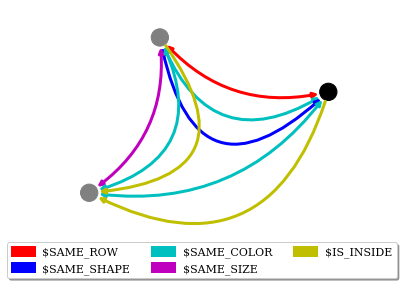

In [707]:
graph = ReaSCANGraph(
    objects=sampled_world["obj_map"], 
    vocabulary=vocabulary,
    positions=sampled_world["pos_map"], 
    referred_object=sampled_world["referred_obj"],
    debug=False
)
graph.draw()

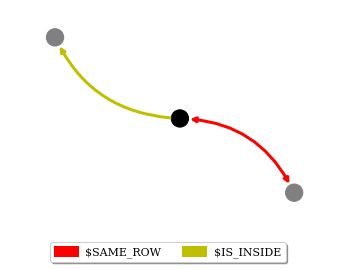

In [708]:
pattern_graph = ReaSCANGraph(
    objects=obj_map, 
    vocabulary=vocabulary,
    relations=rel_map, 
    referred_object='$OBJ_0', 
    debug=False
)
pattern_graph.draw()

In [709]:
graph.find_referred_object(
    pattern_graph, referred_object='$OBJ_0'
)

{'$OBJ_0', '$OBJ_1'}

In [ ]:
print("Command:")
command_str = grammer.repre_str_command(grammer_pattern, rel_map, obj_map)
print(f"walk to {command_str} cautiously")

In [650]:
import networkx as nx

class ReaSCANGraph(object):
    """
    SAME_ROW_REGEX = "$SAME_ROW"
    SAME_COL_REGEX = "$SAME_COLUMN"
    SAME_SHAPE_REGEX = "$SAME_SHAPE"
    SAME_COLOR_REGEX = "$SAME_COLOR"
    SAME_SIZE_REGEX = "$SAME_SIZE"
    IS_INSIDE_REGEX = "$IS_INSIDE"
    """

    def __init__(
        self, objects, vocabulary, 
        relations=None, positions=None, referred_object=None,
        debug=False
    ):
        self.vocabulary = vocabulary
        self.relations = OrderedDict({})
        self.G = nx.MultiDiGraph()
        self.G_full = nx.MultiDiGraph()
        if positions == None:
            # This means it is a abstract pattern, not a grounded shapeWorld graph.
            for obj_name, obj_str in objects.items():
                if referred_object != None and obj_name == referred_object:
                    self.G.add_node(obj_name, type="object", referent=True)
                    self.G_full.add_node(obj_name, type="object", referent=True)
                else:
                    self.G.add_node(obj_name, type="object", referent=False)
                    self.G_full.add_node(obj_name, type="object", referent=False)
                obj_str = obj_str.split(" ")
                if len(obj_str) == 1:
                    if obj_str[0] != "object":
                        self.relations[(obj_name, obj_str[0])] = ['$SHAPE']
                elif len(obj_str) == 2:
                    if obj_str[0] in vocabulary.get_size_adjectives():
                        self.relations[(obj_name, obj_str[0])] = ['$SIZE']
                    elif obj_str[0] in vocabulary.get_color_adjectives():
                        self.relations[(obj_name, obj_str[0])] = ['$COLOR']
                    if obj_str[1] != "object":
                        self.relations[(obj_name, obj_str[1])] = ['$SHAPE']
                elif len(obj_str) == 3:
                    if obj_str[0] in vocabulary.get_size_adjectives():
                        self.relations[(obj_name, obj_str[0])] = ['$SIZE']
                    elif obj_str[0] in vocabulary.get_color_adjectives():
                        self.relations[(obj_name, obj_str[0])] = ['$COLOR']
                    if obj_str[1] in vocabulary.get_size_adjectives():
                        self.relations[(obj_name, obj_str[0])] = ['$SIZE']
                    elif obj_str[1] in vocabulary.get_color_adjectives():
                        self.relations[(obj_name, obj_str[0])] = ['$COLOR']
                    if obj_str[2] != "object":
                        self.relations[(obj_name, obj_str[0])] = ['$SHAPE']

            for edge, relation in relations.items():
                src_node, dst_node = edge[0], edge[1]
                if (src_node, dst_node) not in self.relations:
                    self.relations[(src_node, dst_node)] = [relation]
                else:
                    self.relations[(src_node, dst_node)].append(relation)
                if relation != "$IS_INSIDE":
                    # permutable
                    dst_node, src_node = edge[0], edge[1]
                    if (src_node, dst_node) not in self.relations:
                        self.relations[(src_node, dst_node)] = [relation]
                    else:
                        self.relations[(src_node, dst_node)].append(relation)
            for edge, relations in self.relations.items(): 
                src_node, dst_node = edge[0], edge[1]
                for relation in relations:
                    if relation in ["$SAME_ROW", "$SAME_COLUMN", 
                                    "$SAME_SHAPE", "$SAME_COLOR", 
                                    "$SAME_SIZE", "$IS_INSIDE"]:
                        self.G.add_edge(src_node, dst_node, type=relation)
                    self.G_full.add_edge(src_node, dst_node, type=relation)
            if debug:
                print(self.relations)
        else:
            self.objects = objects
            self.positions = positions
            self.referred_object = referred_object
            relations = self.parse_relations(objects, positions)
            self.relations = relations
            if debug:
                print(self.relations)
            # formulate the graph
            for obj_name, obj in objects.items():
                if referred_object != None and obj_name == referred_object:
                    self.G.add_node(obj_name, type="object", referent=True)
                    self.G_full.add_node(obj_name, type="object", referent=True)
                else:
                    self.G.add_node(obj_name, type="object", referent=False)
                    self.G_full.add_node(obj_name, type="object", referent=False)
            for edge, relations in relations.items():
                src_node, dst_node = edge[0], edge[1]
                for relation in relations:
                    if relation in ["$SAME_ROW", "$SAME_COLUMN", 
                                    "$SAME_SHAPE", "$SAME_COLOR", 
                                    "$SAME_SIZE", "$IS_INSIDE"]:
                        self.G.add_edge(src_node, dst_node, type=relation)
                    self.G_full.add_edge(src_node, dst_node, type=relation)
        self.relation_color_map = {
            "$SAME_ROW" : "r",
            "$SAME_COLUMN" : "g",
            "$SAME_SHAPE" : "b",
            "$SAME_COLOR" : "c",
            "$SAME_SIZE" : "m",
            "$IS_INSIDE" : "y"
        }
        
    def draw(self):
        """
        This function only draws objects and relations, but not attributes.
        """
        G = self.G
        color_map = []
        for node in G.nodes(data=True):
            if node[1]["referent"]:
                color_map.append('black')
            else:
                color_map.append('grey')
        edge_labels=dict(
            [((u,v,),d['type']) for u,v,d in G.edges(data=True)]
        )
            
        import matplotlib.pyplot as plt
        from matplotlib.legend_handler import HandlerTuple
        
        y_off = 0.5
        pos = nx.spring_layout(G)
        
        nx.draw_networkx_nodes(
            G, pos, node_color=color_map
        )

        ax = plt.gca()
        arrow_legend = []
        arrow_label = []
        node_connection_map = {}
        annotation_group_map = {
            "$SAME_ROW" : [],
            "$SAME_COLUMN" : [],
            "$SAME_SHAPE" : [],
            "$SAME_COLOR" : [],
            "$SAME_SIZE" : [],
            "$IS_INSIDE" : []
        }
        for e in G.edges(data=True):
            if ((e[0], e[1]) in node_connection_map and e[2]["type"] in node_connection_map[(e[0], e[1])]) or \
                ((e[1], e[0]) in node_connection_map and e[2]["type"] in node_connection_map[(e[1], e[0])]):
                continue # We draw using bidirectional arrows already!
            if (e[0], e[1]) not in node_connection_map:
                node_connection_map[(e[0], e[1])] = [e[2]["type"]]
            else:
                node_connection_map[(e[0], e[1])].append(e[2]["type"])
            connection_count = len(node_connection_map[(e[0], e[1])])
            if e[2]["type"] == "$IS_INSIDE":
                arrowstyle="<|-"
            else:
                arrowstyle="<|-|>"
            an = ax.annotate(
                "",
                xy=pos[e[0]], xycoords='data',
                xytext=pos[e[1]], textcoords='data',
                arrowprops=dict(
                    lw=3,
                    arrowstyle=arrowstyle, color=self.relation_color_map[e[2]["type"]],
                    shrinkA=10, shrinkB=10,
                    patchA=None, patchB=None,
                    connectionstyle="arc3,rad=rrr".replace('rrr',str(0.3*connection_count)),
                ),
                label = "a"
            )
            annotation_group_map[e[2]["type"]].append(an.arrow_patch)

        groups = []
        legends = []
        for type, group in annotation_group_map.items():
            if len(group) >= 1:
                groups.append(tuple([group[0]]))
                legends.append(type)
        plt.legend(groups, legends, numpoints=1, 
                   handler_map={tuple: HandlerTuple(ndivide=None)}, 
                   loc='upper center', bbox_to_anchor=(0.48, -0.06),
                   ncol=3, fancybox=True, shadow=True, fontsize=11)
        plt.margins(0.2)
        plt.axis('off')
        plt.show()

    def parse_relations(self, objects, positions):
        relations = OrderedDict({})
        
        # Attributes
        for obj_id, obj_spec in objects.items():
            # relations[(obj_id, obj_spec.size)] = "$SIZE"
            relations[(obj_id, obj_spec.color)] = ["$COLOR"]
            relations[(obj_id, obj_spec.shape)] = ["$SHAPE"]

            for to_obj_id, to_obj_spec in objects.items():
                if obj_id != to_obj_id:
                    if to_obj_spec.shape == obj_spec.shape:
                        if obj_spec.size < to_obj_spec.size:
                            relations[(obj_id, "small")] = ["$SIZE"]
                        if obj_spec.size > to_obj_spec.size:
                            relations[(obj_id, "big")] = ["$SIZE"]
        # Relations
        for obj_id_left, obj_spec_left in objects.items():
            for obj_id_right, obj_spec_right in objects.items():
                if obj_id_left != obj_id_right:
                    obj_pos_left = positions[obj_id_left]
                    obj_pos_right = positions[obj_id_right]
                    key = (obj_id_left, obj_id_right)
                    if obj_pos_left.row == obj_pos_right.row:
                        if key not in relations:
                            relations[key] = ["$SAME_ROW"]
                        else:
                            relations[key].append("$SAME_ROW")
                    if obj_pos_left.column == obj_pos_right.column:
                        if key not in relations:
                            relations[key] = ["$SAME_COLUMN"]
                        else:
                            relations[key].append("$SAME_COLUMN")
                    if obj_spec_left.size == obj_spec_right.size:
                        if key not in relations:
                            relations[key] = ["$SAME_SIZE"]
                        else:
                            relations[key].append("$SAME_SIZE")
                    if obj_spec_left.color == obj_spec_right.color:
                        if key not in relations:
                            relations[key] = ["$SAME_COLOR"]
                        else:
                            relations[key].append("$SAME_COLOR")
                    if obj_spec_left.shape == obj_spec_right.shape:
                        if key not in relations:
                            relations[key] = ["$SAME_SHAPE"]
                        else:
                            relations[key].append("$SAME_SHAPE")
                    # For IsInside relations.
                    if obj_spec_right.shape == "box":
                        if obj_pos_left.row >= obj_pos_right.row and \
                            obj_pos_left.row < obj_pos_right.row+obj_spec_right.size and \
                            obj_pos_left.column >= obj_pos_right.column and \
                            obj_pos_left.column < obj_pos_right.column+obj_spec_right.size:
                            if key not in relations:
                                relations[key] = ["$IS_INSIDE"]
                            else:
                                relations[key].append("$IS_INSIDE")
        return relations
    
    def find_referred_object(self, relation_pattern, referred_object="$OBJ_0"):
        from networkx.algorithms import isomorphism
        from networkx import DiGraph
        from networkx import line_graph
        G = self.G_full
        sub_G = relation_pattern.G_full
        line_G = line_graph(DiGraph(G))
        line_sub_G = line_graph(DiGraph(sub_G))

        DiGM = isomorphism.DiGraphMatcher(line_graph(DiGraph(G)), line_graph(DiGraph(sub_G)))
        
        valid_referred_nodes = []
        for edge_match in DiGM.subgraph_isomorphisms_iter():
            valid = True
            for G_pair, sub_G_pair in edge_match.items():
                # First pass: we can check naive node type. They need to match with each other.
                if G_pair[0].startswith("$") and G_pair[0][0] != sub_G_pair[0][0]:
                    valid = False
                    break # not valid.
                if G_pair[1].startswith("$") and G_pair[1][0] != sub_G_pair[1][0]:
                    valid = False
                    break # not valid.
                if not G_pair[1].startswith("$") and G_pair[1] != sub_G_pair[1]:
                    valid = False
                    break # not valid.
                # Second pass: if it is a edge between nodes, we need to match relations.
                if G_pair[0].startswith("$") and G_pair[1].startswith("$") and \
                    sub_G_pair[0].startswith("$") and sub_G_pair[1].startswith("$"):
                    # This is a relational pair.
                    overlap_relations = set(self.relations[G_pair]).intersection(
                        set(relation_pattern.relations[sub_G_pair])
                    )
                    if len(overlap_relations) == 0:
                        valid = False
                        break # not valid.
            if valid:
                pattern_node_map = {}
                for G_pair, sub_G_pair in edge_match.items():
                    if G_pair[0].startswith("$") and G_pair[1].startswith("$") and \
                        sub_G_pair[0].startswith("$") and sub_G_pair[1].startswith("$"):
                        if sub_G_pair[0] not in pattern_node_map:
                            pattern_node_map[sub_G_pair[0]] = G_pair[0]
                        else:
                            if pattern_node_map[sub_G_pair[0]] != G_pair[0]:
                                valid = False
                                break # not valid.
                        if sub_G_pair[1] not in pattern_node_map:
                            pattern_node_map[sub_G_pair[1]] = G_pair[1]
                        else:     
                            if pattern_node_map[sub_G_pair[1]] != G_pair[1]:
                                valid = False
                                break # not valid.
            
            if valid:
                valid_referred_nodes.append(pattern_node_map[referred_object])
        return set(valid_referred_nodes)

### ReaSCAN Dataset

In [15]:
class ReaSCAN(object):
    """
    This contains a couple modules:
    (1) dataset generator.
    (2) dataset splitter.
    (3) dataset stats monitor.
    (4) dataset IO operator.
    (5) dataset tensorer.
    """
    def __init__(self):
        pass